## Introduction

**This is an EDA Analysis concers the Iowa State Salary Book with data from Fiscal year 2007.**

**The dataset and analysis completed in this book are helpful for those in need of job search recommendations -> What factors are influential in my potential pay? Because these are state works, the data can also be useful for the Iowa government -> What sectors are workers under/overpaid? Is there legislation that's necessary to standardize pay for state workers?**

**The dataset houses copious amounts of information, and describes State workers from a diverse array of departments and positions. However, I am most interested in the relation to the Annual Salaries of workers and how it changes across different categorical data.**

## Data Overview

In [59]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
salary_book = pd.read_csv("Iowa_Salary_Book.csv", engine="python",on_bad_lines="skip")

In [60]:
salary_book.info()

<class 'pandas.DataFrame'>
RangeIndex: 282590 entries, 0 to 282589
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Record ID             282590 non-null  int64
 1   Fiscal Year           282590 non-null  int64
 2   Department            282590 non-null  str  
 3   Agency/Institution    85217 non-null   str  
 4   Name                  282590 non-null  str  
 5   Gender                282320 non-null  str  
 6   Place of Residence    279232 non-null  str  
 7   Position              281172 non-null  str  
 8   Base Salary           246284 non-null  str  
 9   Base Salary Date      282590 non-null  str  
 10  Total Salary Paid     281957 non-null  str  
 11  Travel & Subsistence  154432 non-null  str  
dtypes: int64(2), str(10)
memory usage: 50.6 MB


**The given dataset contains information about State employees from the State of Iowa from Fiscal Years 2007-2012. The dataset contains:**
    **282589 entries,
    12 columns,
        2 columns containing integers, and
        10 columns containing strings**

**Many rows in this dataset include commas in their structure (names, salaries, etc.) Unforutnately, this breaks reading in of the csv, causing information to be attributed to the incorrect columns. By adding the parameters 'engine="python"' and 'on_bad_lines="skip",' we're setting up the reading of the csv to be uniform and maintain a usable structure.**

**A small select of columns contain full non-null information. The handling of the rest will be discussed later.**

## Data Cleaning

In [3]:
salary_book.head()

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence
0,200700001,2007,ADMINISTRATIVE SERVICES,NaN,ABELS BEVERLY J,F,POLK,ADVANCED PERSONNEL MGMT,31.62 HR,Jul 2007,"$6,462.34",NaN
1,200700002,2007,ADMINISTRATIVE SERVICES,NaN,ABRAMS JERRY A,M,WAPELLO,EARLY OUT POSITION,TERMINATED,Jul 2007,"$4,242.82",NaN
2,200700003,2007,ADMINISTRATIVE SERVICES,NaN,ADAMS CAROL L,F,MITCHELL,ADVANCED PERSONNEL MGMT,"2,212.80 BW",Jul 2007,"$55,065.60",$924.44
3,200700004,2007,ADMINISTRATIVE SERVICES,NaN,ADAMS JEANNIE R,F,POLK,ACCOUNTING TECHNICIAN 2,"1,226.40 BW",Jul 2007,"$30,800.83",$6.80
4,200700005,2007,ADMINISTRATIVE SERVICES,NaN,ADAMS NED J,M,POLK,EARLY OUT POSITION,TERMINATED,Jul 2007,"$10,634.33",NaN


In [4]:
salary_book.info()

<class 'pandas.DataFrame'>
RangeIndex: 282590 entries, 0 to 282589
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Record ID             282590 non-null  int64
 1   Fiscal Year           282590 non-null  int64
 2   Department            282590 non-null  str  
 3   Agency/Institution    85217 non-null   str  
 4   Name                  282590 non-null  str  
 5   Gender                282320 non-null  str  
 6   Place of Residence    279232 non-null  str  
 7   Position              281172 non-null  str  
 8   Base Salary           246284 non-null  str  
 9   Base Salary Date      282590 non-null  str  
 10  Total Salary Paid     281957 non-null  str  
 11  Travel & Subsistence  154432 non-null  str  
dtypes: int64(2), str(10)
memory usage: 50.6 MB


**Many of the columns in this dataset suffer from null values. In some cases, we can assume this is purposeful, such as Travel & Subsistence or Agency/Institution, due to the large proportion of missing values. However, we can infer that errors occurred in some columns, like Gender or Position, and null values will be unuseful for our future analysis. Therefore, we will remove some select rows with null values for select columns.**

In [5]:
salary_book.dropna(subset=['Gender','Place of Residence','Position'], inplace=True)

**While working with the salary book, a large part of our analysis will deal with the salaries of employees. However, there is no standardization in their salaries that can allow annual salaries to be calculated outright. For example, the following are all the different non-numerical tags associated with describing base salary:**

In [6]:
salary_book['Salary Tags'] = (
    salary_book["Base Salary"]
    .astype(str)
    .str.upper()
    .str.replace(r"[\d\.,\s]", "", regex=True)
)
sorted(salary_book["Salary Tags"].dropna().unique())

['',
 '$',
 '$HR',
 '$YR',
 '--',
 '/HR',
 'AN',
 'BW',
 'DA',
 'DAILY',
 'HR',
 'HRLY',
 'ONLEAVE',
 'TERMINATED',
 'YR']

**As seen, employee salaries could be written 5 different ways, and still be representing annual salary. To standardize salaries, we can create a column focused on the numeric portion of the Base Salary column called 'Numeric Salaries.' Then, using the separated Salary Tags, we can create a helper function that will take in the tag and complete the appropriate calculation needed to represent an annual salary for a given employee.**

In [7]:
salary_book['Numeric Salary'] = salary_book['Base Salary'].str.replace(r"\s+", "", regex=True).str.replace(r"[$,]", "", regex=True).str.extract(r"([\d\.]+)").astype(float)

In [8]:
# Helper function to standardize annual salary depending on pay period given in Base Salary
def total_salary(row):
    base_salary = str(row['Salary Tags'])
    pay = row['Numeric Salary']

    if pd.isna(pay):
        return None 
    elif "BW" == base_salary:
        return round(26 * pay, 2) # Assuming 26 pay periods
    elif ("HR" == base_salary) or ("$HR" == base_salary) or ("/HR" == base_salary) or ("HRLY" == base_salary):
        return round(2080 * pay, 2) # Assuming 2080 hours for full time workers
    elif ("DA" == base_salary) or ("DAILY" == base_salary):
        return round(260 * pay, 2) # Assuming 260 pay periods
    elif ("$" == base_salary) or ("$YR" == base_salary) or ("YR" == base_salary) or ("AN" == base_salary) or ("" == base_salary):
        return round(1 * pay, 2) # Assuming these are the proper form to already be annual salaries
    else:
        return round(pay, 2) # Catching any tags that have no applicable salary (Terminated, On Leave, etc.)

In [9]:
salary_book['Annual Salary'] = salary_book.apply(total_salary, axis=1)

In [10]:
salary_book.sample(5)

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
271445,201124004,2011,IOWA STATE UNIVERSITY,NaN,NIEHM LINDA S,F,STORY,ASSOC PROF,"85,541.00",Jul 2011,"$92,464.11","$3,007.24",,85541.0,85541.0
56265,200756235,2007,UNIVERSITY OF IOWA,NaN,"ANDERSON,DANIEL D",M,JOHNSON,PROFESSOR,119500,Jul 2007,"$174,825.91","$1,374.20",,119500.0,119500.0
245457,201057117,2010,UNIVERSITY OF NORTHERN IOWA,NaN,NASH CHRISTY L,F,POTTAWATTAM,SECRETARY III,"49,631",Jul 2010,"$46,753.80",$116.69,,49631.0,49631.0
97694,200829992,2008,JUDICIAL,NaN,WILKERSON PAMELA R,F,CEDAR,JUDICIAL CLERK 3,"1,743.20 BW",Jul 2008,"$43,757.60",$279.90,BW,1743.2,45323.2
44855,200744854,2007,UNIVERSITY OF NORTHERN IOWA,NaN,HAACK JOEL K,M,BLACK HAWK,DEAN & PROFESSOR,160000,Jul 2007,"$155,000.04","$10,119.45",,160000.0,160000.0


**As seen, each employee's salary is in a comparable format that allows for future analysis! Now that we have an additional non-string column, I did a sanity check and viewed some stats of the new Annual Salary Column.**

In [11]:
salary_book['Annual Salary'].describe()

count    2.251900e+05
mean     5.441596e+04
std      2.792130e+05
min      0.000000e+00
25%      3.725280e+04
50%      4.761120e+04
75%      6.180000e+04
max      7.639840e+07
Name: Annual Salary, dtype: float64

In [12]:
salary_book.loc[salary_book['Annual Salary'] == 7.639840e+07]

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
205651,201017315,2010,IOWA SCHOOL FOR THE DEAF,NaN,"CHAPPELL, BRENDA",F,SARPY,RESIDENTIAL COUNSELOR,"$36,730.00 HR",Jul 2010,"$36,112.00",NaN,$HR,36730.0,76398400.0


**As seen, there was at least one iteration of an employee whose base salary was incorrectly reported as being tens of thousands of dollar an hour. As such, her annual salary was in the millions and is skewing the statistics of the Annual Salary Column. Without further context from the source of the dataset, it's safe to assume this was a mistake, however, there's no information about what changes need to be made. Does she make $36730/year, or the hourly equivalent of that? To be safe, we'll create a copy of the dataframe with a cap on the displayed Annual Salaries.**

In [13]:
capped_salary = salary_book[salary_book["Annual Salary"] < 4000000]

In [14]:
capped_salary['Annual Salary'].describe()

count    2.251840e+05
mean     5.331032e+04
std      3.476520e+04
min      0.000000e+00
25%      3.725280e+04
50%      4.761120e+04
75%      6.180000e+04
max      1.470000e+06
Name: Annual Salary, dtype: float64

**Most of the employees are classified as F or M for their gender. However, there are nonstandard entries as well:**

In [15]:
capped_salary['Gender'].value_counts()

Gender
F     123082
M     102098
*          3
FM         1
Name: count, dtype: int64

In [16]:
capped_salary.loc[(capped_salary['Gender'] == '*')]

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
206113,201017777,2010,IOWA STATE UNIVERSITY,NaN,ATKINSON DEBRA JO,*,**,SENIOR LECTURER,-0-,Jul 2010,"$3,126.72",$0.00,--,0.0,0.0
211434,201023101,2010,IOWA STATE UNIVERSITY,NaN,MILLER DAWN MARIE,*,**,PROGRAM ASST II,-0-,Jul 2010,"$1,463.96",$0.00,--,0.0,0.0
265445,201117997,2011,IOWA STATE UNIVERSITY,NaN,ANEX ROBERT P JR,*,DANE,PROF,-0-,Jul 2011,"$22,500.00","$1,824.70",--,0.0,0.0


In [17]:
capped_salary.loc[(capped_salary['Gender'] == 'FM')]

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
26297,200726235,2007,TRANSPORTATION,NaN,"REDEKER, FRANCIS 'FRANK'",FM,JEFFERSON,ENG TECH SR,"2,447.20 BW",Jul 2007,"$64,624.15","$1,362.57",BW,2447.2,63627.2


**There is not sufficient context for the treatment of these workers, so for gender analysis, we will exclude them. However, they will still be included in other comparisons, such as Department or Travel & Subsistence analysis.**

In [18]:
gendered_salary = capped_salary[(capped_salary["Gender"] == 'F') | (capped_salary["Gender"] == "M")] # Ver. of dataframe that only contains people gendered by F or M

## Analysis

**The dataset describes several categorical pieces of information for the various workers represented. Some categories are regularly represented as...**

### Fiscal Year Analysis

In [43]:
capped_salary['Fiscal Year'].value_counts()

Fiscal Year
2010    50204
2009    48779
2008    48052
2007    47248
2011    30871
2012       30
Name: count, dtype: int64

**Evidently, the salary book was not throughly well-managed throughout the years. Aside from the lack of standardization of the various columns, the salary book had tens of thousands of entries each fiscal year until 2012.**

In [41]:
capped_salary.groupby('Fiscal Year')['Annual Salary'].mean()

Fiscal Year
2007    53074.159455
2008    55586.459617
2009    55654.601287
2010    51952.564772
2011    48650.623327
2012    34902.966667
Name: Annual Salary, dtype: float64

**Most of the fiscal years have mean annual salaries around the same value (hitting the 40-50 thousands of dollars). Due to 2012 only having 30 entries, the mean annual salary is vastly different. Because the salary book ends in 2012, it is likely that the lack of upkeep is due to the state government shifting their bookeeping to a different dataset, abandoning the one analyzed in this EDA.**

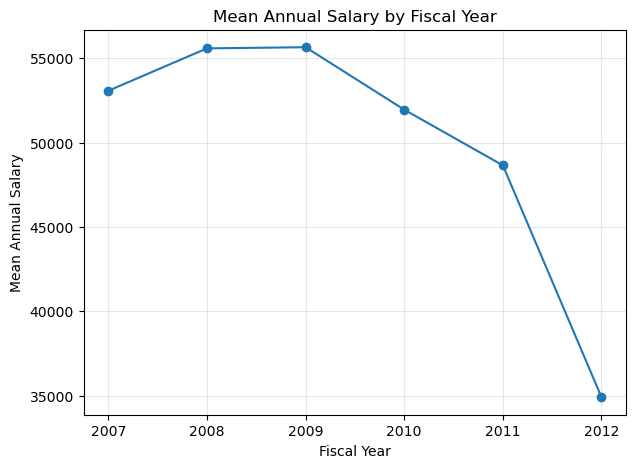

In [48]:
mean_salary_by_year = (capped_salary.groupby("Fiscal Year")["Annual Salary"].mean().sort_index())
plt.figure(figsize=(7, 5))

plt.plot(
    mean_salary_by_year.index,
    mean_salary_by_year.values,
    marker="o"
)

plt.xlabel("Fiscal Year")
plt.ylabel("Mean Annual Salary")
plt.title("Mean Annual Salary by Fiscal Year")

plt.grid(True, alpha=0.3)
plt.show()

In [62]:
capped_salary.loc[(capped_salary['Fiscal Year'] == 2012)].sample(5)

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
212038,201235019,2012,REVENUE,NaN,NEAL PATRICK J,M,POLK,EXEC OFF 2,"3,242.40 BW",Jul 2012,"$85,797.80",$0.00,BW,3242.4,84302.4
187735,201226149,2012,IOWA STATE UNIVERSITY,NaN,TU KEWEI,M,STORY,CASUAL HOURLY,-0-,Jul 2012,"$2,475.00","$2,558.66",--,0.0,0.0
185818,201222837,2012,IOWA STATE UNIVERSITY,NaN,MCAFEE ELISA KATHLEE,F,POLK,**,-0-,Jul 2012,"$1,634.48",$0.00,--,0.0,0.0
184751,201218644,2012,IOWA STATE UNIVERSITY,NaN,CHEN LE,F,SANTA CLARA,CASUAL HOURLY,-0-,Jul 2012,"$1,700.00",$0.00,--,0.0,0.0
188889,201228588,2012,JUDICIAL,NaN,BROWNELL MARIA E,F,POLK,LAW CLERK 3,"2,000.80 BW",Jul 2012,"$52,963.20",$117.44,BW,2000.8,52020.8


**Furthermore, the 2012 Fiscal Year represents a lot of nontraditional salary workers whose base salary is marked as 0, bringing the average down on a year that already has so few entries.**

### Department Analysis

**With initial data cleaning complete, we can now further inspect columns of interest and mkae note of information that will be useful in future multivariate analysis. There are many unique departments under the salary book, but for the sake of brevity, thorough analysis will concern the top five departments (University of Iowa, Iowa State University, Human Service, transportation, and Corrections) who make up 56.24% of the total dataset.**

In [61]:
capped_salary['Department'].value_counts().sample(10)

Department
FINANCE AUTHORITY               469
ETHIC & CAMPAIGN DISCLOSURE      27
TREASURER                       108
HUMAN RIGHTS                    268
REGENTS                         686
JUDICIAL                       9289
LOTTERY AUTHORITY               543
PUBLIC SAFETY                  4935
COLLEGE STUDENT AID             252
ATTORNEY GENERAL               1245
Name: count, dtype: int64

In [31]:
select_departments_salary = capped_salary[(capped_salary['Department']=='IOWA STATE UNIVERSITY') | (capped_salary['Department']=='UNIVERSITY OF IOWA') | (capped_salary['Department']=='HUMAN SERVICES') | (capped_salary['Department']=='TRANSPORTATION') | (capped_salary['Department']=='CORRECTIONS')]

**As seen, there is a wide variety of Departments represented in this dataset. They range from workers in various Iowa universities to more niche departments in Law Enforcement and Parole Officers. The University of Iowa holds the most amount of workers with their workforce totaling 23% of the entire dataset. As mentioned, we will examine the top five departments in the following:**

In [32]:
select_departments_salary.groupby('Department')['Position'].describe()

,count,unique,top,freq
Department,,,,
CORRECTIONS,14677,163,CORRECTIONAL OFFICER,7547
HUMAN SERVICES,26928,259,RESIDENT TREATMENT WORKE,4802
IOWA STATE UNIVERSITY,35874,636,CASUAL HOURLY,5029
TRANSPORTATION,15559,192,HT ASSOCIATE,2694
UNIVERSITY OF IOWA,65914,945,STAFF NURSE,5947


In [49]:
select_departments_salary.groupby('Department')['Gender'].describe()

,count,unique,top,freq
Department,,,,
CORRECTIONS,14677,2,M,9893
HUMAN SERVICES,26928,2,F,19631
IOWA STATE UNIVERSITY,35874,3,M,18351
TRANSPORTATION,15559,3,M,11639
UNIVERSITY OF IOWA,65914,2,F,40519


**In these departments, the gender breakdown is rarely close to a 50/50 split except Iowa state University. Every other university has a strong lean of either men or women in their departments. The specific gender breakdown has a logical connection with the position breakdown described earlier where positions with higher amounts of "masculine" jobs have more men (like Corrections Officer). A similar relationship is seen with jobs that are more "feminine," like Staff Nurse. Iowa State's top job is Casual Hourly, a vague title that provides logic for the more even gender split for that Department as a whole.**

In [33]:
select_departments_salary.groupby('Department')['Annual Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Department,,,,,,,,
CORRECTIONS,14677.0,51959.241764,19335.594627,13000.0,42744.0,50793.6,53372.8,259459.2
HUMAN SERVICES,26928.0,47432.517357,16083.398864,18865.6,38043.2,44158.4,54080.0,254363.2
IOWA STATE UNIVERSITY,35874.0,47035.092111,39898.613094,0.0,22870.2,44218.5,63162.0,850000.0
TRANSPORTATION,15559.0,51356.269208,17459.801812,10000.0,40788.8,46924.8,59508.8,151604.7
UNIVERSITY OF IOWA,65914.0,58195.019601,47771.787767,0.0,36000.5,47460.0,63000.0,1470000.0


**On average, the highest paid workers are in the University of Iowa, the largest university in the state. Similar to Iowa State University, as a large university, there is a large spread in different salaries for workers. Mentioned above, staff Nurse is the highest frequency of worker, but there is still a large variety in employees, from professors to coaches to non-traditionally staffed individuals (people whose Base Salary/Annual Salary are thus labeled as 0). The pay gap between workers in the same university are outstanding with the highest paid worker making 1.47 million dollars while even the top 75% is only making 63,000 dollars. Department is evidently incredibly influential on the annual salary of workers, but niche positions may have a greater influence.**

### Gender Analysis

**As mentioned in the data cleaning section, gender analysis will be ignoring nonstandard gender markers from the dataset to avoid assumptions.**

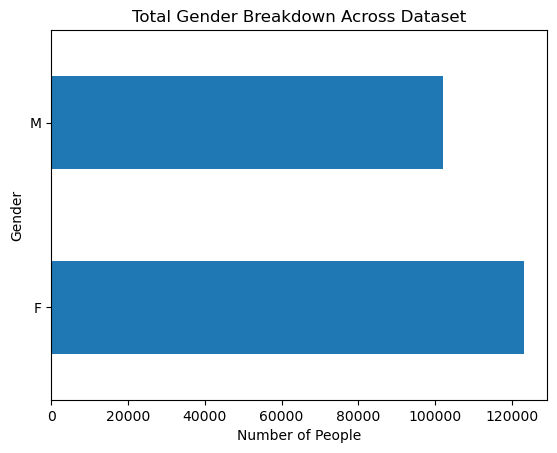

In [36]:
gender_counts = gendered_salary['Gender'].value_counts().sort_index()

gender_counts.plot(kind='barh',legend=False)

plt.xlabel("Number of People")
plt.ylabel("Gender")
plt.title("Total Gender Breakdown Across Dataset")

plt.show()

**It is important to note that because the dataset spans several fiscal years, there are repeat individuals whose columns are subject to change in each iteration. In general, the Iowa State Salary Book represents more women in the workforce than men.**

In [37]:
gendered_salary.groupby('Gender')['Annual Salary'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,123082.0,48363.018967,25198.366436,0.0,35817.6,44782.4,56650.0,501668.0
M,102098.0,59275.897231,42837.661960,0.0,39291.2,50793.6,69555.2,1470000.0


In [39]:
gendered_salary.loc[gendered_salary['Annual Salary'] == 1470000.0]

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
58926,200758899,2007,UNIVERSITY OF IOWA,NaN,"FERENTZ,KIRK J",M,JOHNSON,HEAD COACH,1470000,Jul 2007,"$2,765,000.00","$4,919.05",,1470000.0,1470000.0
114203,200846462,2008,UNIVERSITY OF IOWA,NaN,"FERENTZ,KIRK J",M,JOHNSON,HEAD COACH,"1,470,000.00",Jul 2008,"$2,870,000.00","$9,153.45",,1470000.0,1470000.0
175458,200947499,2009,UNIVERSITY OF IOWA,NaN,"FERENTZ,KIRK J",M,JOHNSON,HEAD COACH,"$1,470,000.00",Jul 2009,"$3,070,000.00","$4,715.99",$,1470000.0,1470000.0
234437,201046110,2010,UNIVERSITY OF IOWA,NaN,"FERENTZ,KIRK J",M,JOHNSON,HEAD COACH,1470000,Jul 2010,"$3,295,000.00","$3,892.73",,1470000.0,1470000.0


In [40]:
gendered_salary.loc[gendered_salary['Annual Salary'] == 501668.0]

,Record ID,Fiscal Year,Department,Agency/Institution,Name,Gender,Place of Residence,Position,Base Salary,Base Salary Date,Total Salary Paid,Travel & Subsistence,Salary Tags,Numeric Salary,Annual Salary
234345,201046018,2010,UNIVERSITY OF IOWA,NaN,"FAJARDO,LAURIE LEE",F,JOHNSON,PROFESSOR,501668,Jul 2010,"$461,395.42","$9,631.21",,501668.0,501668.0


**Though women make up a higher percentage of the salary book, men are on average higher earners than them by over 10 thousand dollars. The highest earning man is Head Coach Kirk J Ferentz from the University of Iowa making 1.47 million dollars throughought several fiscal years. University of Iowa is a top ranked football team, so it is logical that the head coach of their team would be paid so highly. In the same department, the highest earning woman is Professor Laurie Lee Fajardo, making a little less than half of Coach Ferentz at 501.6 thousand dollars. Professor Fajardo is a Research Professor in Radiology. The football team is likely an important source of revenue for the school, providing explanation for the difference in price towards its coaches compared to professors. The gender pay gap is expected as with trends with industries as a whole, but it is interesting to compare high paying masculine departments (like the high salaried coaches in the University of Iowa) influence the gender breakdown of salary.**

## Conclusion

**On average, the highest salaried state workers from Iowa are men who work at the University of Iowa, particularly the head coaches of their sports teams. This analysis reveals interesting information about the relationship of sports teams and their perceived value compared to other roles. Through the interesting insights revealed in this analysis, the data could be further compared across other private institutions across Iowa like Ginnell College or Drake University. Another application could be deeper analysis on comparing the pay of Iowa public university workers with those form other states and eventaully creating a breakdown on their pay -> How influential is national ranking the specific sports team?**